 ### 1 SQL - легкий уровень
#### Задание 1.1
Вывести средний размер заработной платы и pos-оборота по территориальным банкам.

In [ ]:
"""
SELECT
    tb_name,
    AVG(sallary),
    AVG(pos_amt)
FROM 
    $clnt_aggr
GROUP BY
    tb_name
"""

#### Задание 1.2 
Вывести распределение клиентов по  территориальным банкам. Учитывать только тех клиентов, у которых pos-оборот  больше  или равен 1000 руб.

In [ ]:
"""
SELECT
    tb_name,
    count(client_dk) as total
FROM 
    $clnt_aggr
WHERE
    pos_amt >= 1000
GROUP BY
    tb_name
ORDER BY
    total DESC
"""

#### Задание 1.3
Вывести  распределение клиентов по  территориальным банкам и группе по возрасту (меньше 18 (включительно), от 18 до 30 (включительно), от 30 до 60(включительно), больше 60 лет).

In [ ]:
"""
SELECT
    a.tb_name,
    SUM(CASE WHEN (b.age <= 18) THEN 1 ELSE 0 END) as 'age_0_18',
    SUM(CASE WHEN (b.age > 18 AND b.age <= 30)  THEN 1 ELSE 0 END) as 'age_18_30',
    SUM(CASE WHEN (b.age > 30 AND b.age <= 60)  THEN 1 ELSE 0 END) as 'age_30_60',
    SUM(CASE WHEN (b.age > 60) THEN 1 ELSE 0 END) as 'age_60_plus'
FROM
    $clnt_aggr as a
INNER JOIN 
    $clnt_data as b
ON a.client_dk = b.client_dk
GROUP BY
    a.tb_name
ORDER BY
    age_0_18 DESC
"""

#### Задание 1.4
Вывести территориальный банк, возраст и заработную плату клиентов, получающих максимальную заработную плату в своем территориальном банке.

In [ ]:
"""
SELECT
    a.tb_name,
    b.age,
    a.max_sallary
FROM (
    SELECT
        tb_name,
        client_dk,
        MAX(sallary) as max_sallary
    FROM 
        $clnt_aggr
    GROUP BY
        tb_name
) as a
INNER JOIN 
    $clnt_data as b
ON a.client_dk = b.client_dk
"""

#### Задание 1.5
Вывести идентификаторы клиентов, у которых  pos-оборот строго больше, чем в среднем по базе.

In [ ]:
"""
SELECT
    client_dk
FROM 
    $clnt_aggr
WHERE
    pos_amt > (SELECT AVG(pos_amt) FROM $clnt_aggr)
"""

#### Задание 1.6*
Перед отпуском руководитель попросил вас: «вывести распределение клиентов по уровню заработной платы*». Необходимо подготовить 1 слайд, который раскроет данную проблематику.

`*Подсказка: задание творческое.  При выполнении задания можно создавать промежуточные таблицы - приложить код и описать графики, которые будут показаны на слайде.`

Я так понимаю, здесь, желательно показать как бы я представил данные.
Я бы отобразил следующее:
    - гистограмму распределения
    - средние величины: мат. ожидание, медиану, моду
    - **возможно** отдельно выделил некоторые специальные значения, например, если будут те, кто получает ниже МРОТ

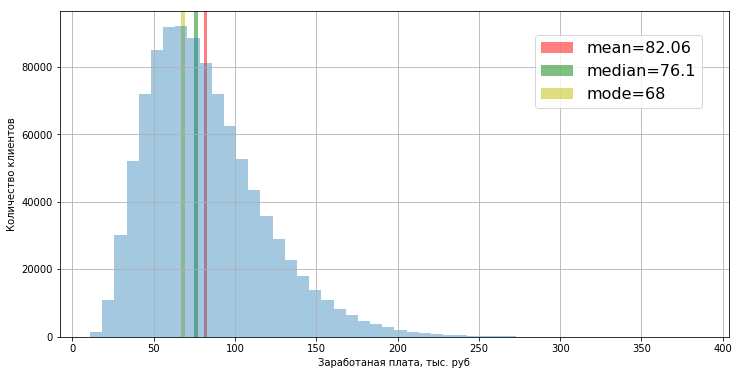

In [98]:
import seaborn as sns
import matplotlib.pyplot as plt
import random
from scipy.stats import mode
from numpy import mean, median

data = [round(random.gammavariate(4, 18),2)+10 for _ in range(1000000)]
mean_, median_, mode_ = [round(mean(data),2), round(median(data),2), round(mode(list(map(round,data)))[0][0],2)] 
                                                                          
plt.figure(figsize=(12, 6))
plt.grid(True)
plt.axvspan(mean_-1, mean_+1, facecolor='r', alpha=0.5)
plt.axvspan(median_-1, median_+1, facecolor='g', alpha=0.5)
plt.axvspan(mode_-1, mode_+1, facecolor='y', alpha=0.5)
plt.ylabel('Количество клиентов')
plt.xlabel('Заработаная плата, тыс. руб')

plt.legend(('mean='+str(mean_), 'median='+str(median_), 'mode='+str(mode_)), loc=(0.71, 0.7), fontsize=16)
ax = sns.distplot(data, kde=False)

### 2 SQL - сложный уровень
#### Задание 2.1 
По каждому клиенту найти кол-во дней (с начала 2019г. до конца июня 2019г.), которое ему потребовалось, чтобы совершить транзакций (расходных операций) на сумму не меньшую, чем его кредитный потенциал. Если он так и не потратил его, то вывести по клиенту значение = 200


* "Не меньшую" - это ">="
* Выходная таблица должна быть в формате:

| client_dk   |took_days|
|-------------|:-------:|
| 213 902 233 |    27   |
| 832 929 999 |    26   |
| 123 123 111 |   200   |
   
* Столбец type(Trx_dt) = date <br>
Допустим, у нас есть библиотека для работы датами DATETIME (я просто не знаю какая стоит у вас, во всех реализация по-разному). <br>
Я буду использовать следующие функции: <br>

     **INTERVAL(date1, date2, scale) - вычисляет разницу между date1 и date2 в единицах scale='day'**



In [ ]:
"""
$pre = (
    SELECT
        client_dk,
        DATETIME.INTERVAL(Trx_dt, DATE('01-01-2019'),'day') as trans_date,
        SUM(Trx_amt) as day_total
    FROM
        $daily_trx
    WHERE
        (Trx_dt >= DATE('01-01-2019') AND Trx_dt < DATE('01-07-2019'))
        AND Trx_type == 'C'
    GROUP BY
        client_dk, trans_date
)

$balanced = (
    SELECT
        *,
        sum(a.day_total) OVER (PARTITION BY a.client_dk ORDER BY a.trans_date ASC) - b.Crd_potential as balance
    FROM 
        $pre as a
    INNER JOIN
        $cred_potential as b
    ON a.client_dk = b.client_dk
)

$only_less_200 = (
    SELECT
        client_dk,
        MIN(trans_date) as took_days
    FROM 
        $balanced
    WHERE
        balance >= 0
    GROUP BY
        client_dk
)

$all_clients = (
    SELECT
        DISTINCT client_dk, '200' as took_days
    FROM
        $daily_trx
    WHERE
        (Trx_dt >= DATE('01-01-2019') AND Trx_dt < DATE('01-07-2019'))
        AND Trx_type == 'C'
)

SELECT
    a.client_dk,
    CASE WHEN b.client_dk THEN b.took_days ELSE a.took_days END as took_days
FROM 
    $all_clients as a
LEFT JOIN 
    $only_less_200 as b
ON a.client_dk = b.client_dk
"""

#### Задание 2.2 
Все то же самое, но теперь учитывать только транзакции в подгруппах mcc кодов, в названиях которых содержится слово «снятие»

*  **LOWER()** - преобразует строку к нижнему регистру

In [ ]:
"""
$pre_merchant_info = (
    SELECT
        Merch_id
    FROM
        $merchant_info
    WHERE
        LOWER(Mcc_name) LIKE '%снятие%'
)

$pre_daily_trx = (
    SELECT
        client_dk,
        DATETIME.INTERVAL(Trx_dt, DATE('01-01-2019'),'day') as trans_date,
        Trx_amt,
        Merch_id
    FROM
        $daily_trx
    WHERE
        (Trx_dt >= DATE('01-01-2019') AND Trx_dt < DATE('01-07-2019'))
        AND Trx_type == 'C'
)

$pre = (
    SELECT
        a.client_dk,
        a.trans_date,
        SUM(a.Trx_amt) as day_total
    FROM
        $pre_daily_trx as a
    INNER JOIN
        $pre_merchant_info as b
    ON a.Merch_id = b.Merch_id
    GROUP BY
        a.trans_date
)

$balanced = (
    SELECT
        *,
        sum(a.day_total) OVER (PARTITION BY a.client_dk ORDER BY a.trans_date ASC) - b.Crd_potential as balance
    FROM
        $pre as a
    INNER JOIN
        $cred_potential as b
    ON a.client_dk = b.client_dk
)
    
$only_less_200 = (
    SELECT
        client_dk,
        MIN(trans_date) as took_days
    FROM 
        $balanced
    WHERE
        balance >= 0
    GROUP BY
        client_dk
)

$all_clients = (
    SELECT
        DISTINCT client_dk, '200' as took_days
    FROM
        $pre
)

SELECT
    a.client_dk,
    CASE WHEN b.client_dk THEN b.took_days ELSE a.took_days END as took_days
FROM 
    $all_clients as a
LEFT JOIN 
    $only_less_200 as b
ON a.client_dk = b.client_dk
"""

#### Задание  2.3 
Опишите логику решения задачи в пункте 2

1. Произведем предобработку, чтобы выделить в __daily_trx__ только транзакции __"%снятие%"__
  1.  С помощью регулярных выражений найдем __Merch_id__ в __merchant_info__, где в __Mcc_name__ содержит слово __"снятие"__  
  2.  В __daily_trx__ преобразуем дату транзакции к формату __"кол-во дней с 01-01-2019"__; исключим "приходные" транзакции; исключим транзакции вне промежутка __"янв.2019 - июнь 2019"__  
  3. Произведем join __(A) и (B)__ по __Merch_id__
  4. "Схлопнем" все транзакции до суммы по дням

2. Найдем динамку для каждого __client_dk__ того, как меняется суммарный расход __(balance)__ с помощью оконной функции
  1. Произведем join __(1.) и cred_potential__ по __client_dk__
  2. С помощью оконной функции получим для каждого __client_dk__ суммарный расход по карте для каждого дня 
3. Для каждого __client_dk__ найдем день, когда __balance впервые__ >= 0, а если он всегда < 0, то выводим 200.

### Бизнес-кейс!
Заказчик просит выделить в клиентской базе Банка клиентов, которых можно привлечь в канал премиального обслуживания для ВИПов. Сейчас в канале 20 тыс. клиентов  - в основном наши зарплатные клиенты, клиенты с высокими балансами или крупными кредитами. Необходимо приземлить задачу на язык данных:

1.	Определить  признаки, которые помогут найти «латентных» ВИПов
2.	Определиться с подходом к решению задачи

__Вопросы 1. и 2. связаны. Поэтому ниже я буду отвечать на вопрос (2.) в теле которого будет дан ответ на вопрос (1.)__

__A. Статистический подход.__
  * Можно воспользоваться статистическими методами: например, убрать признаки имеющие малую дисперсию. В __python-пакете sklearn__ есть класс реализующий этот метод __VarianceThreshold__. 
  * Можно проверить каждый признак с помощью корреляции Пирсона и отсечь не коррелирующие признаки, если правильно выделим целевую переменную (например, если есть численный показатель "ВИПовости" клиента, ниже которого он может лишиться своего статуса "ВИПа").
  
__B. ML подход.__
  * Наверняка у банка также есть канал "не ВИПов" - клиенты о которых мы знаем достаточно много. Имеющих то же (или приблизительно то же) пространство признаков, что и в канале "ВИП-клиентов".
  * Мы можем взять из канала "не ВИПов" 20 тыс. клиентов и смешать их с 20 тыс. "ВИП-клиентами", назначив целевую переменную "является ли клиент ВИПом".
  * Обучим несколько моделей классификации: метод опорных векторов (__SVM__), случайный лес (__Random Forest__). Посчитаем качество кросс-валидацией, возможно, "покрутим" параметры при которых достигается наибольшее качество моделей. Выделим важность признаков в этих методах. Например, в __python-пакете sklearn__, для этих моделей есть метод __feature_importances___, возращающий наиболее важные числовые признаки для этих моделей.
  
__C. Агрегированный подход.__
  * Можем обучить ещё несколько ML-моделей (использующих другие методы) или взять реализации методов из __(B.)__ с одинаковым качеством и сравнить множества признаков. Допустим у нас получилось выделить по три разные реализации каждого из двух методов с разным набором признаков. 
  * Добавим к ним статистические тесты дисперсии и корреляции Пирсона и построим следующую таблицу:

| Algorithm / Feature   |Feat.1|Feat.1|Feat.1|....|Feat.N|
|-----------------------|:----:|:----:|:----:|:--:|:----:|
| VarianceThreshold     |   0  |   1  |   0  |....|   0  |
| Pearson Corr.         |   0  |   1  |   1  |....|   1  |
| RandomForest v1       |   1  |   0  |   0  |....|   0  |
| RandomForest v2       |   1  |   1  |   0  |....|   0  |
|        ...            |  ... |  ... |  ... |....|  ... |
| SVM v2                |   0  |   1  |   0  |....|   0  |
| SVM v3                |   1  |   0  |   1  |....|   1  |
| **TOTAL**             |   6  |   3  |   4  |....|   2  |

Мы можем выделить какие признаки чаще встречались в разных моделях/реализациях и, например, отобрать лишь признаки встречающиеся 6 и более раз.
  
__D. Метод перебора.__ 
  * Более (вычислительно) сложный подход - это построить модель, обученную на подмножестве признаков доставляющих максимальное качество классификации.
  * Нужно использовать обертку над каким-то ML-алгоритмом, использующую перебор: итеративно на каждом шаге добавлять или убирать признаки, в зависимости от того, как меняется качество классификации. Это вычислительно объемная задача, но например, можно применить метод главных компонент (__PCA__), уменьшив размерность пространства признаков, что может на порядки уменьшить наши вычислительные затраты.